In [2]:
import numpy as np 
import geopandas as gpd 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import pandas as pd 
from shapely.geometry import shape 
# from shapely.geometry import Polygon 
import json 
from shapely import wkt 
from shapely.geometry import Point
from shapely.geometry import box
from math import cos, radians
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
import seaborn as sns 
import contextily as ctx
from scipy.spatial import cKDTree
import xarray as xr

In [6]:
# !pip install censusdata

In [5]:
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import censusdata
import contextily as ctx

In [16]:
# df = pd.read_csv('California_SVI_Census_Tracts.csv')

In [17]:
# fp = '../Data/fires_perimeter.geojson'

In [18]:
# gdf = gpd.read_file(fp)

## Social Vulnerability Index 

* CDC/ATSDR Social Vulnerability Index
* The degree to which a community exhibits certain social conditions, including high poverty, low percentage of vehicle access, or
crowded households, among others 

#### 4 Themes 
* Socioeconomic Status - RPL_THEME1
* Household Characteristics - RPL_THEME2
* Racial & Ethnic Minority Status - RPL_THEME3
* Housing Type & Transportation - RPL_THEME4 

#### Overall Vulnerability Ranking available as well 
* overall summary ranking variable is RPL_THEMES 

#### The higher the value, the greater the vulnerability 

Documentation can be found here: https://svi.cdc.gov/map25/data/docs/SVI2022Documentation_ZCTA.pdf

In [110]:
svi_cali_census_tracts_fp = '/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/SVI Data/California/California_Census_Tracts.csv'

In [111]:
svi_cali_census_tracts_df = pd.read_csv(svi_cali_census_tracts_fp)

### Filter out LA County & relevant columns (population, 4 SVI themes, population) 

In [112]:
la_svi_census_df = svi_cali_census_tracts_df[svi_cali_census_tracts_df['COUNTY'] == 'Los Angeles County'].reset_index()

In [113]:
la_svi_census_df = la_svi_census_df[['COUNTY', 'FIPS', 'LOCATION', 'AREA_SQMI', 'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES']]
# la_svi_census_df = la_svi_census_df[['COUNTY', 'FIPS', 'LOCATION', 'AREA_SQMI', 'E_TOTPOP', 'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES']]

#### Filter out No Data Values 

In [114]:
la_svi_census_df = la_svi_census_df[~(la_svi_census_df['RPL_THEME1'] == -999)]

In [115]:
la_svi_census_df.head()

,COUNTY,FIPS,LOCATION,AREA_SQMI,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES
0,Los Angeles County,6037101110,Census Tract 1011.10; Los Angeles County; Cali...,0.441083,0.5451,0.4706,0.2738,0.7327,0.5696
1,Los Angeles County,6037101122,Census Tract 1011.22; Los Angeles County; Cali...,1.020871,0.4445,0.2972,0.1327,0.1759,0.2650
2,Los Angeles County,6037101220,Census Tract 1012.20; Los Angeles County; Cali...,0.269841,0.8138,0.7043,0.4151,0.3070,0.6467
3,Los Angeles County,6037101221,Census Tract 1012.21; Los Angeles County; Cali...,0.136749,0.7796,0.8904,0.3104,0.9294,0.8717
4,Los Angeles County,6037101222,Census Tract 1012.22; Los Angeles County; Cali...,0.114484,0.8608,0.7279,0.3847,0.7175,0.7934


In [116]:
# la_svi_census_df.describe()

### Shapefiles of LA Census Tracts 

Data source: https://redistricting.lacounty.gov/mapping-files-data-download/ 

In [117]:
la_census_gdf = gpd.read_file('/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/LA_Census_Shapefile/tl_2020_06_tract_LACounty/tl_2020_06_tract_LACounty.shp')

In [118]:
la_census_gdf['GEOID'] = la_census_gdf['GEOID'].astype(int)

In [119]:
la_census_gdf = la_census_gdf.rename(columns = {'GEOID':'FIPS'})

In [120]:
la_census_gdf.head()

,STATEFP,COUNTYFP,TRACTCE,FIPS,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,06,037,262601,6037262601,2626.01,Census Tract 2626.01,G5020,S,3620351.0,0.0,+34.0738344,-118.5557893,0.108596,0.000354,"POLYGON ((-118.57556 34.08019, -118.57497 34.0..."
1,06,037,300100,6037300100,3001,Census Tract 3001,G5020,S,4591342.0,18657.0,+34.2442558,-118.2325716,0.094693,0.000451,"POLYGON ((-118.2486 34.23881, -118.24858 34.23..."
2,06,037,300501,6037300501,3005.01,Census Tract 3005.01,G5020,S,1260255.0,0.0,+34.2206887,-118.2400494,0.061435,0.000123,"POLYGON ((-118.24875 34.22249, -118.24875 34.2..."
3,06,037,310701,6037310701,3107.01,Census Tract 3107.01,G5020,S,515339.0,0.0,+34.1853923,-118.3128440,0.036201,0.000050,"POLYGON ((-118.31952 34.18495, -118.31915 34.1..."
4,06,037,300200,6037300200,3002,Census Tract 3002,G5020,S,1943986.0,10136.0,+34.2283768,-118.2386852,0.067506,0.000191,"POLYGON ((-118.24864 34.23324, -118.24863 34.2..."


### Filter out relevant columns 

In [121]:
la_census_gdf = la_census_gdf[['TRACTCE', 'FIPS', 'NAMELSAD', 'geometry']]

In [122]:
la_census_gdf.head()

,TRACTCE,FIPS,NAMELSAD,geometry
0,262601,6037262601,Census Tract 2626.01,"POLYGON ((-118.57556 34.08019, -118.57497 34.0..."
1,300100,6037300100,Census Tract 3001,"POLYGON ((-118.2486 34.23881, -118.24858 34.23..."
2,300501,6037300501,Census Tract 3005.01,"POLYGON ((-118.24875 34.22249, -118.24875 34.2..."
3,310701,6037310701,Census Tract 3107.01,"POLYGON ((-118.31952 34.18495, -118.31915 34.1..."
4,300200,6037300200,Census Tract 3002,"POLYGON ((-118.24864 34.23324, -118.24863 34.2..."


In [123]:
# la_census_gdf.crs

#### Combine LA Census Tract Gdf & Social Vulnerability Index Data 

In [124]:
merged_df = la_census_gdf.merge(la_svi_census_df, on='FIPS', how='left')  

In [125]:
merged_df[['RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES']] = merged_df[['RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES']].clip(0, 1)

In [126]:
merged_df.head()

,TRACTCE,FIPS,NAMELSAD,geometry,COUNTY,LOCATION,AREA_SQMI,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES
0,262601,6037262601,Census Tract 2626.01,"POLYGON ((-118.57556 34.08019, -118.57497 34.0...",Los Angeles County,Census Tract 2626.01; Los Angeles County; Cali...,1.397825,0.0157,0.1756,0.1147,0.1798,0.0454
1,300100,6037300100,Census Tract 3001,"POLYGON ((-118.2486 34.23881, -118.24858 34.23...",Los Angeles County,Census Tract 3001; Los Angeles County; California,1.772726,0.1202,0.6954,0.3303,0.0461,0.1428
2,300501,6037300501,Census Tract 3005.01,"POLYGON ((-118.24875 34.22249, -118.24875 34.2...",Los Angeles County,Census Tract 3005.01; Los Angeles County; Cali...,0.486587,0.3837,0.5165,0.3783,0.3389,0.3841
3,310701,6037310701,Census Tract 3107.01,"POLYGON ((-118.31952 34.18495, -118.31915 34.1...",Los Angeles County,Census Tract 3107.01; Los Angeles County; Cali...,0.198973,0.7527,0.9799,0.1847,0.8449,0.8577
4,300200,6037300200,Census Tract 3002,"POLYGON ((-118.24864 34.23324, -118.24863 34.2...",Los Angeles County,Census Tract 3002; Los Angeles County; California,0.750577,0.2250,0.2607,0.3394,0.3347,0.2405


#### Vulnerability Themes (Normalized from 0 to 1)  

In [127]:
# merged_df['RPL_THEMES'].describe()

In [128]:
# merged_df[merged_df['AREA_SQMI'].isna()]

#### Reproject to EPSG:32611 -- UTM Zone 11N 

In [129]:
merged_df = merged_df.to_crs('EPSG: 32611')

#### Filter out 'coastal tracts' 

In [130]:
## Use GPS coordinates (from Google Maps) & use a spatial join to filter them out 

point_1 = Point(-118.555579, 34.014150)
gdf_point_1 = gpd.GeoDataFrame([{'geometry': point_1}], crs="EPSG:4326")
gdf_point_1 = gdf_point_1.to_crs('EPSG: 32611')

point_2 = Point(-118.685579, 34.014150)
gdf_point_2 = gpd.GeoDataFrame([{'geometry': point_2}], crs="EPSG:4326")
gdf_point_2 = gdf_point_2.to_crs('EPSG: 32611')

In [131]:
gdf_4 = gpd.sjoin(merged_df, gdf_point_1, how = 'inner', predicate = 'contains')
gdf_5 = gpd.sjoin(merged_df, gdf_point_2, how = 'inner', predicate = 'contains')

gdfs = pd.concat([gdf_4, gdf_5])

In [132]:
merged_df = merged_df[~(merged_df['TRACTCE'].isin(gdfs['TRACTCE'].unique()))]

### Find tracts around Palisade Area 

In [133]:
### Using city in Palisades Area 

point_palisades = Point(-118.546757, 34.044841)
gdf_palisades_point = gpd.GeoDataFrame([{'geometry': point_palisades}], crs="EPSG:4326")
gdf_palisades_point = gdf_palisades_point.to_crs('EPSG: 32611')

In [134]:
### Specify Buffer 

gdf_palisades_point['geometry'] = gdf_palisades_point.geometry.buffer(3e3)
filtered_pali_gdf = gpd.sjoin(merged_df, gdf_palisades_point, how = 'inner', predicate = 'intersects')

In [135]:
merged_df_palisades = merged_df[(merged_df['TRACTCE'].isin(filtered_pali_gdf['TRACTCE'].unique()))]

### Find tracts around Eaton Area  

In [136]:
point_eaton = Point(-118.095058, 34.177908)
gdf_eaton_point = gpd.GeoDataFrame([{'geometry': point_eaton}], crs="EPSG:4326")
gdf_eaton_point = gdf_eaton_point.to_crs('EPSG: 32611')

In [137]:
## Specify Buffer 

gdf_eaton_point['geometry'] = gdf_eaton_point.geometry.buffer(1e3)
filtered_eaton_gdf = gpd.sjoin(merged_df, gdf_eaton_point, how = 'inner', predicate = 'intersects')

In [138]:
merged_df_eaton = merged_df[(merged_df['TRACTCE'].isin(filtered_eaton_gdf['TRACTCE'].unique()))]

### Fire Perimeter Bounds 

In [139]:
fire_perimeter_fp = '/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/fires_perimeter.geojson'

In [140]:
fire_perimeter_gdf = gpd.read_file(fire_perimeter_fp)
fire_perimeter_gdf

,mission_group,OBJECTID,GlobalID,type,source,poly_DateCurrent,mission,incident_name,incident_number,area_acres,...,PercentPerimToBeContained,ModifiedBySystem2,sourceoid,websiteId,websiteDbId,dataverseId,displayStatus,Shape__Area,Shape__Length,geometry
0,Eaton,1269,ea6b6983-73b6-49fa-b467-1081579fb284,Heat Perimeter,FIRIS,2025-01-09 02:29:10.844,CA-LAC-EATON-N57B,Eaton,72660adc-b5ef-4d96-a33f-b4ea3740a4e3,10589.956010,...,None,None,None,dbfa574e-1b10-4467-b5e5-7d1c06ebc8dc,4319,2b91dbc1-79cd-ef11-b8e9-001dd804aa64,Inactive,0.004192,0.818015,"MULTIPOLYGON (((-118.15647 34.18125, -118.1564..."
1,Palisades,1264,0bc1ddb3-63bf-4fd8-a01b-d522f57e4083,Heat Perimeter,FIRIS,2025-01-07 23:17:39.000,CA-LFD-PALISADES-N57B,Palisades,,1261.520779,...,None,None,None,abfed7a3-794a-4294-9852-43176dcbc18a,4318,f0a2f70e-2dcd-ef11-b8e9-001dd804aa64,Active,0.000499,0.342099,"MULTIPOLYGON (((-118.56728 34.04256, -118.5672..."


In [141]:
fire_perimeter_gdf = fire_perimeter_gdf.to_crs(merged_df_palisades.crs)

### Plot of Palisades & Eaton Areas showing Perimeter of Wildfires  

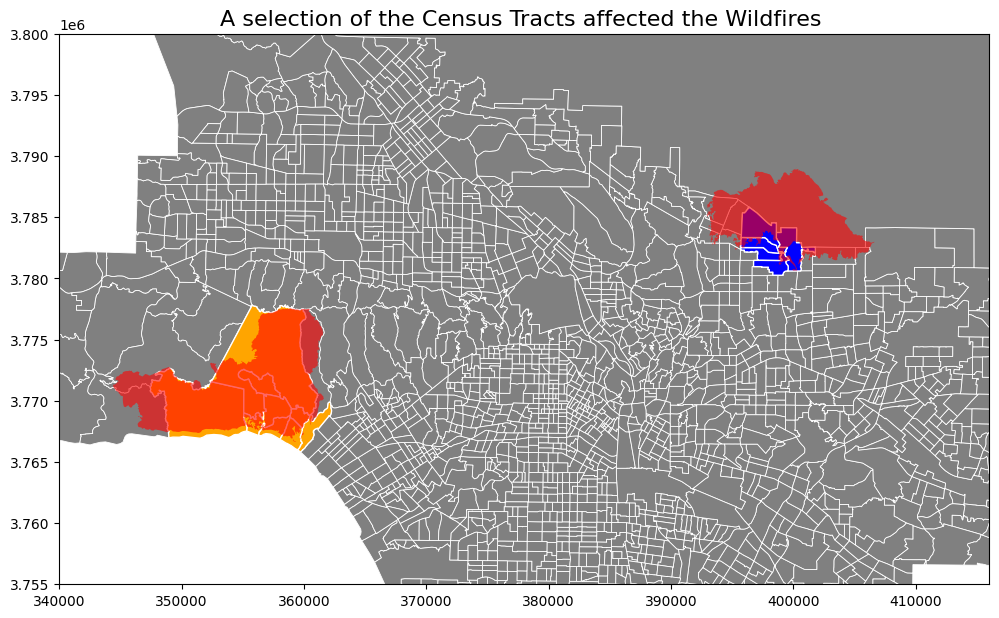

In [144]:
fig, ax = plt.subplots(figsize = (12,10))

# plot all la census tracts 
merged_df.plot(ax = ax, edgecolor = 'white', lw = 0.6, facecolor = 'grey', legend = True, legend_kwds = {'label':'SVI Score'})

# Palisades Area 
merged_df_palisades.plot(ax = ax, facecolor = 'orange', edgecolor = 'white')

# Eaton Area 
merged_df_eaton.plot(ax = ax, facecolor = 'blue', edgecolor = 'white')

# Fire Perimeter Plots 
fire_perimeter_gdf.plot(ax = ax, facecolor = 'red', alpha = 0.6)

# Set Axis Limits 
ax.set_xlim(340000,416000)
ax.set_ylim(3.755e6,3.80e6)

ax.set_title('A selection of the Census Tracts affected the Wildfires ', fontsize = 16)

plt.show()

### Census Data 

In [ ]:
def get_census_data(tables, state, county, year=2019):
    '''Download census data for a given state and county fips code.'''

    # Download the data
    data = censusdata.download('acs5', year,  # Use 2019 ACS 5-year estimates
                               censusdata.censusgeo([('state', state), ('county', county), ('tract', '*')]),
                               list(tables.keys()))

    # Rename the column
    data.rename(columns=tables, inplace=True)

    # Extract information from the first column
    data['Name'] = data.index.to_series().apply(lambda x: x.name)
    data['SummaryLevel'] = data.index.to_series().apply(lambda x: x.sumlevel())
    data['State'] = data.index.to_series().apply(lambda x: x.geo[0][1])
    data['County'] = data.index.to_series().apply(lambda x: x.geo[1][1])
    data['Tract'] = data.index.to_series().apply(lambda x: x.geo[2][1])
    data.reset_index(drop=True, inplace=True)
    data = data[['Tract','Name']+list(tables.values())].set_index('Tract')
    
    return data

def get_census_tract_geom(state_fips, county_fips):
    '''Download census tract geometries for a given state and county fips code, storing in /tmp and cleaning up after.'''

    temp_dir = "/tmp/census_tracts"
    zip_path = os.path.join(temp_dir, f'tl_2019_{state_fips}_tract.zip')

    # Ensure temp directory exists
    os.makedirs(temp_dir, exist_ok=True)

    # Download the file
    url = f'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_{state_fips}_tract.zip'
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise Exception(f"Failed to download file: {url}")

    # Save ZIP file to temp directory
    with open(zip_path, "wb") as file:
        file.write(response.content)

    # Extract the ZIP file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(temp_dir)

    # Find the shapefile in extracted contents
    for file in os.listdir(temp_dir):
        if file.endswith(".shp"):
            shapefile_path = os.path.join(temp_dir, file)
            break

    # Read the shapefile into a GeoDataFrame
    tracts = gpd.read_file(shapefile_path)

    # Filter by county and set index
    tracts = tracts[tracts['COUNTYFP'] == county_fips]
    tracts = tracts.rename(columns={'TRACTCE': 'Tract'}).set_index('Tract')

    # Cleanup: Remove extracted files and ZIP file
    shutil.rmtree(temp_dir)

    return tracts[['geometry']]

### Codes for California & LA County 

In [ ]:
# Define the state and county for LA 
state_fips = '06'  # FIPS code for California 
county_fips = '037'  # FIPS code for LA County

In [ ]:
tables = {
'B19013_001E': 'MedianIncome',
'B01003_001E': 'TotalPopulation',
'B01002_001E': 'MedianAge',
'B17001_002E': 'PopulationBelowPovertyLevel',
'B02001_002E': 'PopulationWhiteAlone',
# 'B02001_003E': 'PopulationBlackAlone',
# 'B02001_004E': 'PopulationAmericanIndianAlaskaNativeAlone',
# 'B02001_005E': 'PopulationAsianAlone',
# 'B02001_006E': 'PopulationNativeHawaiianPacificIslanderAlone',
# 'B02001_007E': 'PopulationSomeOtherRaceAlone',
# 'B02001_008E': 'PopulationTwoOrMoreRaces',
# 'B03002_003E': 'PopulationNotHispanicWhiteAlone',
'B03003_003E': 'PopulationHispanic',
'B25064_001E': 'MedianGrossRent',
'B25077_001E': 'MedianHomeValue',
'B25035_001E': 'MedianYearStructureBuilt',
'B25001_001E': 'TotalHousingUnits',
'B25004_001E': 'TotalVacantHousingUnits',
# 'B25003_002E': 'OccupiedHousingUnitsOwnerOccupied',
# 'B25003_003E': 'OccupiedHousingUnitsRenterOccupied',
'B27001_005E': 'PopulationNoHealthInsuranceCoverage',
}

In [ ]:
census_df = get_census_data(tables, state_fips, county_fips)
# census_df

#### Filter Census Data of interest (population, median income, median home value...) 